<a href="https://colab.research.google.com/github/Chanura04/ML-Coursework/blob/main/20240955.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install keras-tuner 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, models
SEED = 42
tf.random.set_seed(SEED)

## Load the dataset

In [3]:
url_x = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/set_02/X.csv"
url_y = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/set_02/y_data.csv"

## Check dataset behaviour

In [4]:
X=pd.read_csv(url_x)
y=pd.read_csv(url_y)
X.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,-1,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,34,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,2,1,0,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,45,0,-1,1,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,2,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [5]:
X.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [6]:
X.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge', 'IsNewCustomer',
       'IsHighCharge', 'Monthly_Tenure_Ratio', 'Total_Monthly_Ratio',
       'TotalServices', 'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [7]:
y.head()

,Churn
0,0
1,0
2,1
3,0
4,1


In [8]:
X.shape

(7043, 31)

In [9]:
y.shape

(7043, 1)

In [10]:
cols=[ 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'
       ]

if set(cols) == set(X.columns):
    print("All columns are present.")
else:
    missing = set(cols) - set(X.columns)
    extra = set(X.columns) - set(cols)
    if missing:
        print("Missing columns:", missing)
    if extra:
        print("Extra columns:", extra)

Extra columns: {'IsNewCustomer', 'InternetService_DSL', 'TotalServices', 'IsHighCharge', 'AvgMonthlyCharge', 'Monthly_Tenure_Ratio', 'Total_Monthly_Ratio', 'Contract_Month-to-month', 'PaymentMethod_Bank transfer (automatic)'}


### Split Data into Training, Validation, and Test Sets

In [11]:
X_train, X_temp, y_train, y_temp= train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4930, 31)
Shape of y_train: (4930, 1)
Shape of X_val: (1056, 31)
Shape of y_val: (1056, 1)
Shape of X_test: (1057, 31)
Shape of y_test: (1057, 1)


In [12]:
np.sum(y_val==1)

c:\Users\chanu\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Churn    280
dtype: int64

In [13]:
np.sum(y_val==0)

Churn    776
dtype: int64

In [14]:
# Initialize the scaler
scaler = StandardScaler()

# FIT AND TRANSFORM the training data 
X_train = scaler.fit_transform(X_train)

# TRANSFORM the test data 
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [15]:
X_train[0]

array([-0.43814715, -0.96295739, -0.65086184, -1.11472828,  0.33445908,
       -0.4980904 , -0.10182582, -0.17864867, -0.17914794, -0.10933053,
        1.08149216, -0.23031519, -1.20529512,  0.50428615, -0.83650447,
        0.15846124,  1.94586941,  1.2628289 ,  0.86704288, -1.11758834,
       -0.35455473, -0.72059725,  1.12453737, -0.52587133,  0.90731739,
       -0.51517027, -0.5647009 , -0.53152442, -0.52555704,  1.40735673,
       -0.54312331])

In [16]:
y_train = y_train.squeeze()    
y_val   = y_val.squeeze()
y_test  = y_test.squeeze()

Text(0.5, 1.0, 'Count Plot for Churn')

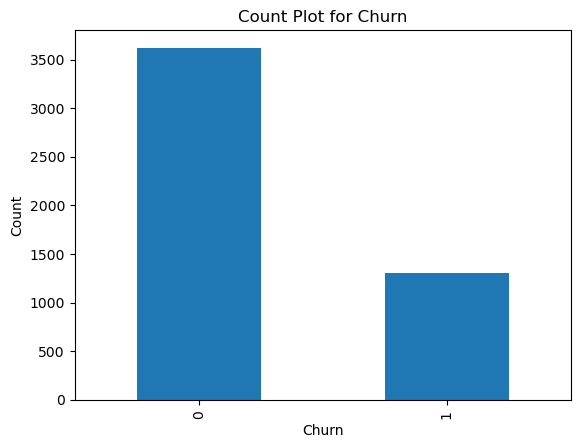

In [17]:
count=y_train.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

Text(0.5, 1.0, 'Count Plot for Churn')

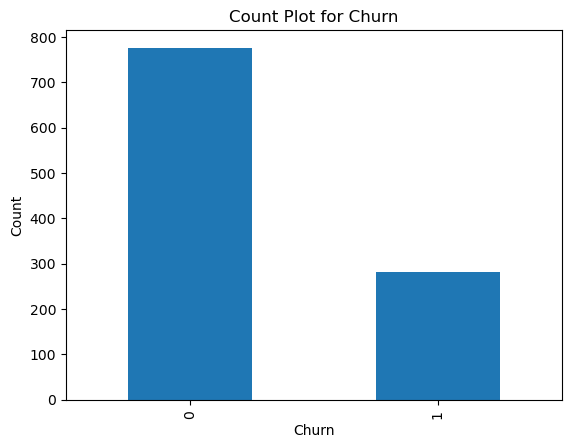

In [18]:
count=y_test.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

In [19]:
def plot_history(history):
    # Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy")
    plt.legend()


    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # AUC
    plt.subplot(1,3,3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title("AUC Curve")
    plt.xlabel("Epochs")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()


## Train Neural Network

#### Experiment 01

In [20]:
input_dim=X_train.shape[1]
input_dim

31

In [21]:
print("Final shape:", X_train.shape)

Final shape: (4930, 31)


In [22]:
len(X.columns)

31

In [23]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
set_seed=42
os.environ['PYTHONHASHSEED'] = str(set_seed)

def create_final_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
    
        
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build model
input_dim = X_train.shape[1]
model = create_final_model(input_dim)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True, mode='min'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, mode='min'
    ),
    callbacks.ModelCheckpoint(
        'best_churn_model_val_loss.h5', monitor='val_loss', save_best_only=True, mode='min'
    )
]

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=1024,
    callbacks=callbacks_list,
    class_weight=class_weight_dict,
    verbose=2
)

Class weights: {0: np.float64(0.680563224737714), 1: np.float64(1.8845565749235473)}
Epoch 1/200


5/5 - 2s - 400ms/step - accuracy: 0.5953 - auc: 0.5148 - loss: 0.8906 - precision: 0.2674 - recall: 0.3020 - val_accuracy: 0.5786 - val_auc: 0.5915 - val_loss: 0.7057 - val_precision: 0.3270 - val_recall: 0.5571 - learning_rate: 0.0010
Epoch 2/200


5/5 - 0s - 22ms/step - accuracy: 0.6460 - auc: 0.6196 - loss: 0.7483 - precision: 0.3642 - recall: 0.4480 - val_accuracy: 0.6477 - val_auc: 0.7010 - val_loss: 0.6659 - val_precision: 0.4013 - val_recall: 0.6679 - learning_rate: 0.0010
Epoch 3/200


5/5 - 0s - 20ms/step - accuracy: 0.6665 - auc: 0.6825 - loss: 0.6767 - precision: 0.4021 - recall: 0.5275 - val_accuracy: 0.6989 - val_auc: 0.7595 - val_loss: 0.6462 - val_precision: 0.4562 - val_recall: 0.7071 - learning_rate: 0.0010
Epoch 4/200


5/5 - 0s - 34ms/step - accuracy: 0.6949 - auc: 0.7314 - loss: 0.6245 - precision: 0.4464 - recall: 0.6239 - val_accuracy: 0.7263 - val_auc: 0.7908 - val_loss: 0.6323 - val_precision: 0.4895 - val_recall: 0.7464 - learning_rate: 0.0010
Epoch 5/200


5/5 - 0s - 20ms/step - accuracy: 0.6992 - auc: 0.7500 - loss: 0.6097 - precision: 0.4545 - recall: 0.6690 - val_accuracy: 0.7415 - val_auc: 0.8090 - val_loss: 0.6192 - val_precision: 0.5085 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 6/200


5/5 - 0s - 20ms/step - accuracy: 0.6994 - auc: 0.7660 - loss: 0.5929 - precision: 0.4559 - recall: 0.6881 - val_accuracy: 0.7396 - val_auc: 0.8196 - val_loss: 0.6069 - val_precision: 0.5060 - val_recall: 0.7571 - learning_rate: 0.0010
Epoch 7/200


5/5 - 0s - 21ms/step - accuracy: 0.7097 - auc: 0.7805 - loss: 0.5775 - precision: 0.4700 - recall: 0.7355 - val_accuracy: 0.7453 - val_auc: 0.8263 - val_loss: 0.5949 - val_precision: 0.5129 - val_recall: 0.7786 - learning_rate: 0.0010
Epoch 8/200


5/5 - 0s - 20ms/step - accuracy: 0.7099 - auc: 0.7853 - loss: 0.5736 - precision: 0.4703 - recall: 0.7393 - val_accuracy: 0.7500 - val_auc: 0.8299 - val_loss: 0.5836 - val_precision: 0.5189 - val_recall: 0.7857 - learning_rate: 0.0010
Epoch 9/200


5/5 - 0s - 20ms/step - accuracy: 0.7166 - auc: 0.7935 - loss: 0.5602 - precision: 0.4779 - recall: 0.7347 - val_accuracy: 0.7491 - val_auc: 0.8326 - val_loss: 0.5740 - val_precision: 0.5176 - val_recall: 0.7893 - learning_rate: 0.0010
Epoch 10/200


5/5 - 0s - 19ms/step - accuracy: 0.7270 - auc: 0.7947 - loss: 0.5591 - precision: 0.4904 - recall: 0.7408 - val_accuracy: 0.7500 - val_auc: 0.8349 - val_loss: 0.5655 - val_precision: 0.5185 - val_recall: 0.8000 - learning_rate: 0.0010
Epoch 11/200


5/5 - 0s - 20ms/step - accuracy: 0.7187 - auc: 0.7938 - loss: 0.5604 - precision: 0.4803 - recall: 0.7370 - val_accuracy: 0.7538 - val_auc: 0.8366 - val_loss: 0.5581 - val_precision: 0.5231 - val_recall: 0.8071 - learning_rate: 0.0010
Epoch 12/200


5/5 - 0s - 22ms/step - accuracy: 0.7211 - auc: 0.7978 - loss: 0.5574 - precision: 0.4834 - recall: 0.7439 - val_accuracy: 0.7538 - val_auc: 0.8381 - val_loss: 0.5510 - val_precision: 0.5230 - val_recall: 0.8107 - learning_rate: 0.0010
Epoch 13/200


5/5 - 0s - 22ms/step - accuracy: 0.7290 - auc: 0.8027 - loss: 0.5511 - precision: 0.4930 - recall: 0.7538 - val_accuracy: 0.7557 - val_auc: 0.8394 - val_loss: 0.5447 - val_precision: 0.5251 - val_recall: 0.8214 - learning_rate: 0.0010
Epoch 14/200


5/5 - 0s - 20ms/step - accuracy: 0.7310 - auc: 0.8121 - loss: 0.5336 - precision: 0.4956 - recall: 0.7676 - val_accuracy: 0.7538 - val_auc: 0.8402 - val_loss: 0.5392 - val_precision: 0.5223 - val_recall: 0.8357 - learning_rate: 0.0010
Epoch 15/200


5/5 - 0s - 20ms/step - accuracy: 0.7296 - auc: 0.8062 - loss: 0.5424 - precision: 0.4937 - recall: 0.7531 - val_accuracy: 0.7519 - val_auc: 0.8410 - val_loss: 0.5350 - val_precision: 0.5199 - val_recall: 0.8393 - learning_rate: 0.0010
Epoch 16/200


5/5 - 0s - 20ms/step - accuracy: 0.7394 - auc: 0.8152 - loss: 0.5288 - precision: 0.5058 - recall: 0.7699 - val_accuracy: 0.7500 - val_auc: 0.8416 - val_loss: 0.5308 - val_precision: 0.5176 - val_recall: 0.8393 - learning_rate: 0.0010
Epoch 17/200


5/5 - 0s - 20ms/step - accuracy: 0.7292 - auc: 0.8073 - loss: 0.5380 - precision: 0.4932 - recall: 0.7538 - val_accuracy: 0.7528 - val_auc: 0.8428 - val_loss: 0.5266 - val_precision: 0.5211 - val_recall: 0.8393 - learning_rate: 0.0010
Epoch 18/200


5/5 - 0s - 36ms/step - accuracy: 0.7329 - auc: 0.8150 - loss: 0.5267 - precision: 0.4977 - recall: 0.7592 - val_accuracy: 0.7500 - val_auc: 0.8439 - val_loss: 0.5223 - val_precision: 0.5174 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 19/200


5/5 - 0s - 20ms/step - accuracy: 0.7377 - auc: 0.8207 - loss: 0.5210 - precision: 0.5037 - recall: 0.7729 - val_accuracy: 0.7481 - val_auc: 0.8446 - val_loss: 0.5191 - val_precision: 0.5150 - val_recall: 0.8571 - learning_rate: 0.0010
Epoch 20/200


5/5 - 0s - 20ms/step - accuracy: 0.7351 - auc: 0.8241 - loss: 0.5179 - precision: 0.5005 - recall: 0.7813 - val_accuracy: 0.7462 - val_auc: 0.8450 - val_loss: 0.5169 - val_precision: 0.5129 - val_recall: 0.8536 - learning_rate: 0.0010
Epoch 21/200


5/5 - 0s - 19ms/step - accuracy: 0.7375 - auc: 0.8186 - loss: 0.5266 - precision: 0.5035 - recall: 0.7706 - val_accuracy: 0.7453 - val_auc: 0.8457 - val_loss: 0.5147 - val_precision: 0.5118 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 22/200


5/5 - 0s - 20ms/step - accuracy: 0.7365 - auc: 0.8196 - loss: 0.5253 - precision: 0.5022 - recall: 0.7867 - val_accuracy: 0.7462 - val_auc: 0.8460 - val_loss: 0.5133 - val_precision: 0.5129 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 23/200


5/5 - 0s - 21ms/step - accuracy: 0.7379 - auc: 0.8188 - loss: 0.5256 - precision: 0.5039 - recall: 0.7875 - val_accuracy: 0.7472 - val_auc: 0.8462 - val_loss: 0.5120 - val_precision: 0.5142 - val_recall: 0.8393 - learning_rate: 0.0010
Epoch 24/200


5/5 - 0s - 20ms/step - accuracy: 0.7347 - auc: 0.8202 - loss: 0.5256 - precision: 0.5000 - recall: 0.7745 - val_accuracy: 0.7462 - val_auc: 0.8465 - val_loss: 0.5109 - val_precision: 0.5132 - val_recall: 0.8357 - learning_rate: 0.0010
Epoch 25/200


5/5 - 0s - 21ms/step - accuracy: 0.7333 - auc: 0.8227 - loss: 0.5183 - precision: 0.4983 - recall: 0.7813 - val_accuracy: 0.7443 - val_auc: 0.8469 - val_loss: 0.5105 - val_precision: 0.5107 - val_recall: 0.8536 - learning_rate: 0.0010
Epoch 26/200


5/5 - 0s - 19ms/step - accuracy: 0.7391 - auc: 0.8256 - loss: 0.5133 - precision: 0.5054 - recall: 0.7882 - val_accuracy: 0.7405 - val_auc: 0.8470 - val_loss: 0.5093 - val_precision: 0.5064 - val_recall: 0.8464 - learning_rate: 0.0010
Epoch 27/200


5/5 - 0s - 19ms/step - accuracy: 0.7404 - auc: 0.8228 - loss: 0.5211 - precision: 0.5069 - recall: 0.7890 - val_accuracy: 0.7405 - val_auc: 0.8474 - val_loss: 0.5087 - val_precision: 0.5064 - val_recall: 0.8464 - learning_rate: 0.0010
Epoch 28/200


5/5 - 0s - 19ms/step - accuracy: 0.7353 - auc: 0.8282 - loss: 0.5098 - precision: 0.5007 - recall: 0.7936 - val_accuracy: 0.7396 - val_auc: 0.8479 - val_loss: 0.5083 - val_precision: 0.5053 - val_recall: 0.8464 - learning_rate: 0.0010
Epoch 29/200


5/5 - 0s - 19ms/step - accuracy: 0.7355 - auc: 0.8263 - loss: 0.5135 - precision: 0.5010 - recall: 0.7875 - val_accuracy: 0.7396 - val_auc: 0.8481 - val_loss: 0.5078 - val_precision: 0.5053 - val_recall: 0.8464 - learning_rate: 0.0010
Epoch 30/200


5/5 - 0s - 19ms/step - accuracy: 0.7387 - auc: 0.8257 - loss: 0.5146 - precision: 0.5048 - recall: 0.7959 - val_accuracy: 0.7405 - val_auc: 0.8486 - val_loss: 0.5072 - val_precision: 0.5064 - val_recall: 0.8464 - learning_rate: 0.0010
Epoch 31/200


5/5 - 0s - 19ms/step - accuracy: 0.7402 - auc: 0.8288 - loss: 0.5109 - precision: 0.5067 - recall: 0.7852 - val_accuracy: 0.7405 - val_auc: 0.8490 - val_loss: 0.5065 - val_precision: 0.5064 - val_recall: 0.8464 - learning_rate: 0.0010
Epoch 32/200


5/5 - 0s - 21ms/step - accuracy: 0.7361 - auc: 0.8325 - loss: 0.5061 - precision: 0.5017 - recall: 0.7920 - val_accuracy: 0.7405 - val_auc: 0.8488 - val_loss: 0.5061 - val_precision: 0.5064 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 33/200


5/5 - 0s - 20ms/step - accuracy: 0.7367 - auc: 0.8297 - loss: 0.5081 - precision: 0.5024 - recall: 0.8005 - val_accuracy: 0.7396 - val_auc: 0.8488 - val_loss: 0.5053 - val_precision: 0.5053 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 34/200


5/5 - 0s - 20ms/step - accuracy: 0.7465 - auc: 0.8298 - loss: 0.5093 - precision: 0.5143 - recall: 0.7974 - val_accuracy: 0.7396 - val_auc: 0.8492 - val_loss: 0.5040 - val_precision: 0.5053 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 35/200


5/5 - 0s - 19ms/step - accuracy: 0.7465 - auc: 0.8351 - loss: 0.5011 - precision: 0.5143 - recall: 0.7982 - val_accuracy: 0.7396 - val_auc: 0.8495 - val_loss: 0.5028 - val_precision: 0.5053 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 36/200


5/5 - 0s - 23ms/step - accuracy: 0.7365 - auc: 0.8302 - loss: 0.5067 - precision: 0.5022 - recall: 0.7966 - val_accuracy: 0.7405 - val_auc: 0.8498 - val_loss: 0.5021 - val_precision: 0.5064 - val_recall: 0.8500 - learning_rate: 0.0010
Epoch 37/200
5/5 - 0s - 29ms/step - accuracy: 0.7448 - auc: 0.8339 - loss: 0.5044 - precision: 0.5121 - recall: 0.8073 - val_accuracy: 0.7396 - val_auc: 0.8500 - val_loss: 0.5023 - val_precision: 0.5054 - val_recall: 0.8393 - learning_rate: 0.0010
Epoch 38/200
5/5 - 0s - 20ms/step - accuracy: 0.7416 - auc: 0.8344 - loss: 0.5035 - precision: 0.5082 - recall: 0.8089 - val_accuracy: 0.7386 - val_auc: 0.8499 - val_loss: 0.5034 - val_precision: 0.5043 - val_recall: 0.8393 - learning_rate: 0.0010
Epoch 39/200
5/5 - 0s - 16ms/step - accuracy: 0.7349 - auc: 0.8328 - loss: 0.5026 - precision: 0.5002 - recall: 0.7898 - val_accuracy: 0.7405 - val_auc: 0.8499 - val_loss: 0.5046 - val_precision: 0.5064 - val_recall: 0.8464 - learning_rate: 0.0010
Epoch 40/200
5/5 - 0s

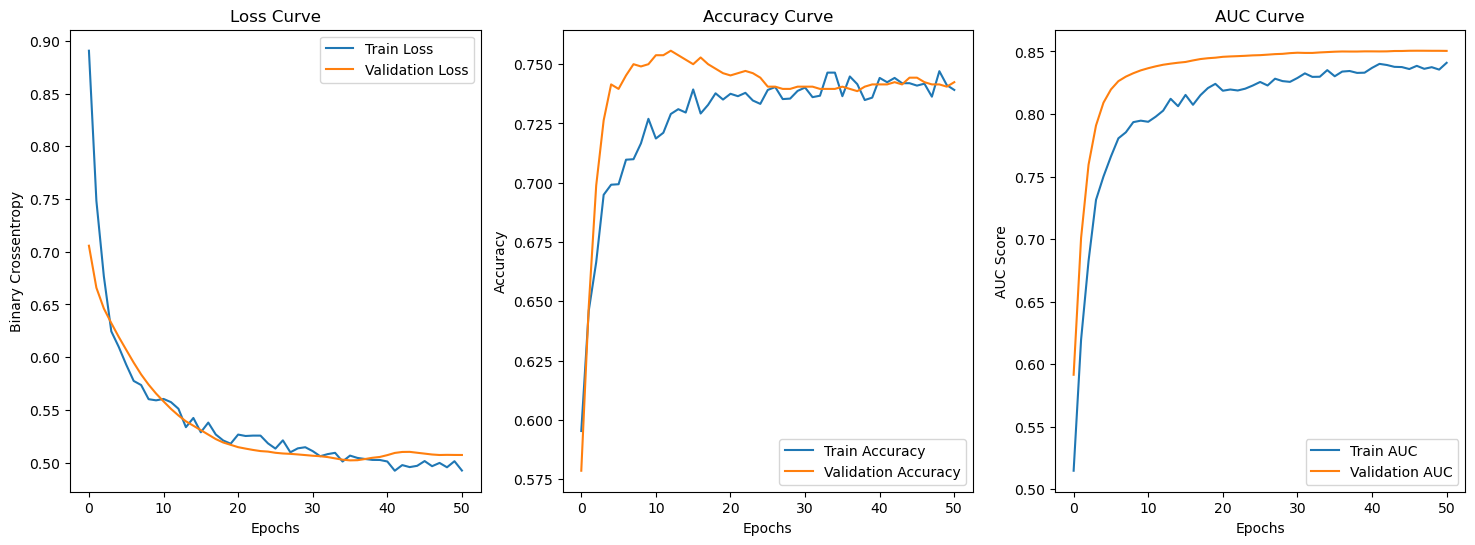

In [24]:
plot_history(history)

In [32]:
best_model_2 = keras.models.load_model('best_churn_model_val_loss.h5')
test_results = best_model_2.evaluate(X_test, y_test, verbose=0)

print(f"Test AUC: {roc_auc_score(y_test, best_model_2.predict(X_test)):.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")
print(f"Test Precision: {precision_score(y_test, (best_model_2.predict(X_test) >= 0.62).astype(int)):.4f}")
print(f"Test Recall: {recall_score(y_test, (best_model_2.predict(X_test) >=  0.62).astype(int)):.4f}")

print("Classification Report:")
print(classification_report(y_test, (best_model_2.predict(X_test) >= 0.64).astype(int)))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test AUC: 0.8495
Test Accuracy: 0.8497
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
Test Precision: 0.5987
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
Test Recall: 0.6690
Classification Report:
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       776
           1       0.62      0.64      0.63       281

    accuracy                           0.80      1057
   macro avg       0.74      0.75      0.74      1057
weighted avg       0.80      0.80      0.80      1057



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Axes: >

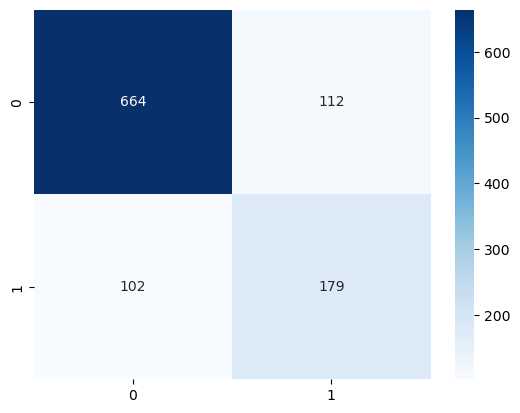

In [26]:
cm=confusion_matrix(y_test, (best_model_2.predict(X_test) >= 0.64).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


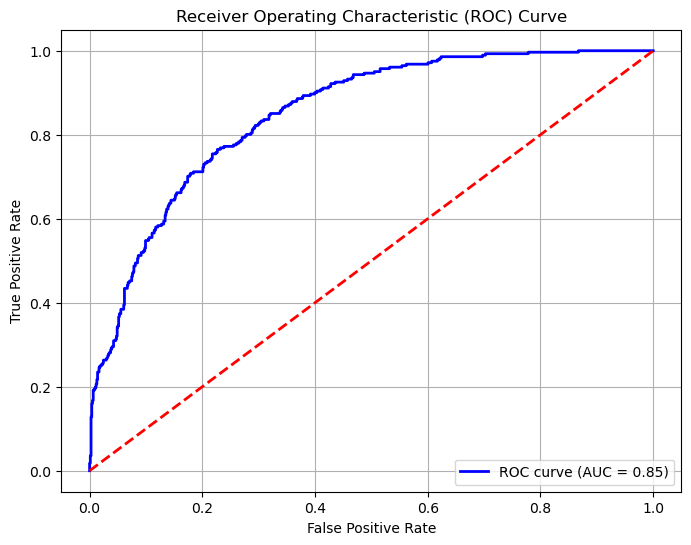

In [27]:
y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()